# K-Means Iris dataset

In [59]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy.stats import mode
import numpy as np
from sklearn.metrics import silhouette_score



In [60]:
RANDOM_SEED = 9
DATASPLIT = 0.3
DATASET_ID= 53

In [61]:
logger = logging.getLogger(str(DATASET_ID))
logging.basicConfig(level=logging.DEBUG)

In [62]:
dataset = fetch_ucirepo(id=DATASET_ID)

df = pd.DataFrame(dataset.data.features)

label_encoder = LabelEncoder()

df['class'] = label_encoder.fit_transform(dataset.data.targets)

df = df.replace("?", pd.NA).dropna()

scaler = StandardScaler()

data = scaler.fit_transform(df)

labels = df['class']

df = df.drop(columns=['class'])



data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=DATASPLIT, random_state=RANDOM_SEED)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size=DATASPLIT, random_state=RANDOM_SEED)

logger.info(f"Train dataset length: {len(data_train)}, Validation dataset length: {len(data_val)}, Test dataset length: {len(data_test)}")

print(df.head())




/home/hedlund01/SynologyDrive/LTU/D7041E/Miniproject/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:53:Train dataset length: 73, Validation dataset length: 32, Test dataset length: 45


   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2


In [63]:


parameters = {
    'n_clusters': range(2, 10, 1),
    'max_iter': range(100, 500, 100),
}


clf = GridSearchCV(KMeans(random_state=RANDOM_SEED), parameters, scoring='accuracy', verbose=1)
clf.fit(data_val, label_val)

model = clf.best_estimator_
logger.info("Best cross-validation score: %f", clf.best_score_)
logger.info("With parameters: %s", clf.best_params_)

logger.info("Training model with best parameters")
model.fit(data_train, label_train)

predictions = model.predict(data_test)

   
mapped_labels = np.zeros_like(predictions)
for i in range(clf.best_params_['n_clusters']):  
    mask = (predictions == i)
    if np.sum(mask) > 0:  # Check if the mask is not empty
        mapped_labels[mask] = mode(label_test[mask])[0]
    else:
        mapped_labels[mask] = -1  # Assign a default value if the mask is empty



accuracy = accuracy_score(label_test, mapped_labels)
logger.info("Accuracy: %f", accuracy)

f1 = f1_score(label_test, mapped_labels, average='weighted')
logger.info("F1 score: %f", f1)

ari = adjusted_rand_score(label_test, mapped_labels)
logger.info("ARI score: %f", ari)

sil = silhouette_score(data_test, mapped_labels)
logger.info("Silhouette score: %f", sil)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


INFO:53:Best cross-validation score: 0.180952
INFO:53:With parameters: {'max_iter': 100, 'n_clusters': 7}
INFO:53:Training model with best parameters
INFO:53:Accuracy: 1.000000
INFO:53:F1 score: 1.000000
INFO:53:ARI score: 1.000000
INFO:53:Silhouette score: 0.581916


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7e303870b6e0>


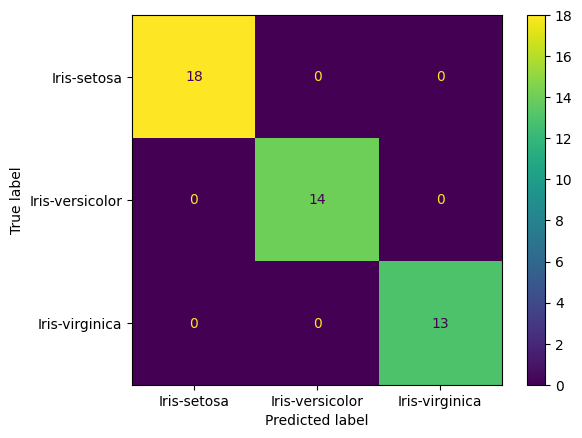

In [64]:
cm = confusion_matrix(label_test, mapped_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()


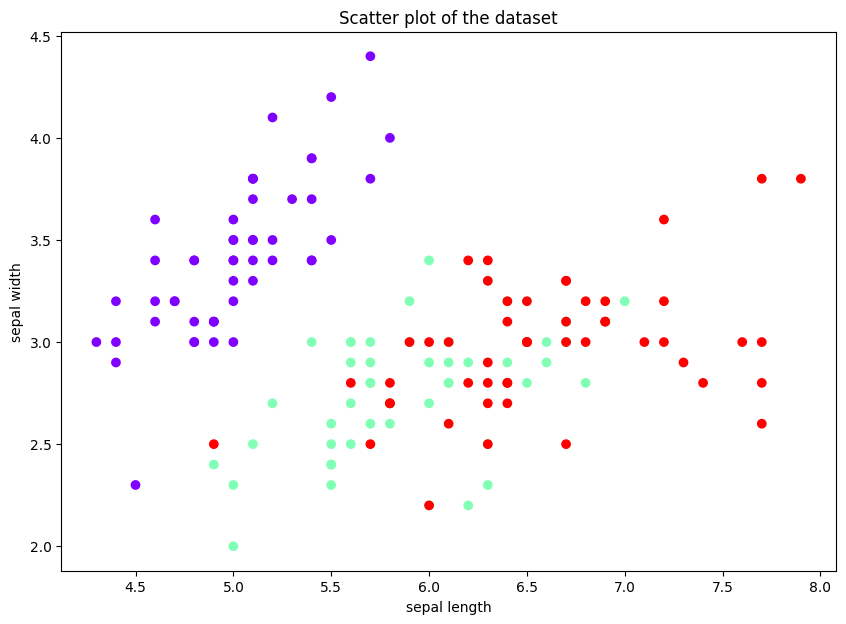

In [65]:

plt.figure(figsize=(10, 7))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels, cmap='rainbow')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title("Scatter plot of the dataset")
plt.show()